In [11]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import subprocess
from ultralytics import YOLO
import time
from collections import deque
from scipy.signal import savgol_filter,butter,filtfilt

In [2]:
localizer = YOLO("../models/Screen_Yolov8.pt")

In [14]:

# FFmpeg command
ffmpeg_cmd = [
    "ffmpeg",
    "-f", "avfoundation",  # Use AVFoundation input
    "-framerate", "25",    # Set frame rate
    "-video_size", "256x384",  # Set resolution
    "-pixel_format", "yuyv422",  # Set input pixel format
    "-i", "0",  # Camera index (change if needed)
    "-f", "rawvideo",  # Output as raw video
    "-pix_fmt", "bgr24",  # Convert to OpenCV-friendly format
    "-"  # Output to stdout
]

# Start FFmpeg process
process = subprocess.Popen(ffmpeg_cmd, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL, bufsize=10**8)

width, height = 256, 384 # Set resolution

frame_number = 0
infer_time = []
start_time = time.time()

# Initialize a deque to store nasal respiration signal (max length 300 frames)
nasal_resp = deque(maxlen=500)
nasal_resp.append(0)  # Start with a zero value to avoid empty deque issues

while True:
    # Read one frame from FFmpeg output
    frame_size = width * height * 3  # BGR24 has 3 channels
    frame_bytes = process.stdout.read(frame_size)

    if not frame_bytes:
        break  # End of stream

    # Convert bytes to numpy array
    frame = np.frombuffer(frame_bytes, np.uint8).reshape((height, width, 3))

    imdata,thdata = np.array_split(frame, 2)

    imdata = cv.resize(imdata, (512,384), interpolation = cv.INTER_CUBIC)

    # Run object detection (e.g., YOLO) on the visible image
    results = localizer(imdata, verbose=False)

    # If any bounding boxes are detected
    if results[0].boxes.shape[0] != 0:
        # Extract box data (x1, y1, x2, y2, confidence, class)
        boxes = results[0].boxes.data.cpu().numpy()
        infer_time.append(results[0].speed['inference'])

        # Filter boxes for class '2' (2 is Nose class)
        noses = boxes[boxes[:, 5] == 2]

        # If any nose detections are found
        if noses.shape[0] != 0:
            # Choose the largest bounding box (by area) as the most prominent nose
            max_nose = np.argmax((noses[:, 3] - noses[:, 1]) * (noses[:, 2] - noses[:, 0]))
            xn1, yn1, xn2, yn2, conf, cls = map(int, noses[max_nose])

            # Compute the mean intensity in the nose region (proxy for nasal airflow)
            nasal_resp.append(np.mean(imdata[yn1:yn2, xn1:xn2]))
        else:
            # If no nose detected, repeat the last value to maintain continuity
            nasal_resp.append(nasal_resp[-1])

        # Draw bounding boxes for all detected objects
        for box in boxes:
            x1, y1, x2, y2, conf, cls = map(int, box)
            cv.rectangle(imdata, (x1, y1), (x2, y2), (0, 255, 0), 1)

        # Highlight the selected nose region in red
        if noses.shape[0] != 0:
            cv.rectangle(imdata, (xn1, yn1), (xn2, yn2), (0, 0, 255), 1)

    # Display the processed visible image
    cv.imshow('Thermal Image', imdata)
    frame_number += 1

    # Dirty Way to Plot but Fast
    if len(nasal_resp) > 200 :
        # Filter and normalize the signal
        signal = savgol_filter(nasal_resp, 51, 3)
        signal = np.array(signal)[20:-25]
        signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal) + 1e-5)  # Normalize to 0-1

        # Plot settings
        plot_width = 600
        plot_height = 200
        plot_img = np.ones((plot_height, plot_width, 3), dtype=np.uint8) * 255

        # Convert signal to pixel coordinates
        points = []
        for i in range(1, len(signal)):
            x1 = int((i - 1) / len(signal) * plot_width)
            y1 = int((1 - signal[i - 1]) * plot_height)
            x2 = int(i / len(signal) * plot_width)
            y2 = int((1 - signal[i]) * plot_height)
            points.append(((x1, y1), (x2, y2)))

        # Draw signal as lines
        for pt1, pt2 in points:
            cv.line(plot_img, pt1, pt2, (255, 0, 0), 2)

        # Add labels (optional)
        cv.putText(plot_img, 'Nasal Respiration', (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)

        # Show the plot
        cv.imshow('Nasal Respiration Plot', plot_img)

    if cv.waitKey(1) & 0xFF == ord("q"):
        cv.waitKey(1)
        cv.destroyAllWindows()
        break

end_time = time.time()
fps = frame_number / (end_time - start_time)
print(f"Processed {frame_number} frames")
print(f"Average FPS: {fps:.2f}")
print(f"Average inference time: {np.mean(infer_time):.2f} ms")

# Cleanup
process.terminate()
cv.waitKey(1)
cv.destroyAllWindows()

Processed 555 frames
Average FPS: 24.03
Average inference time: 17.94 ms


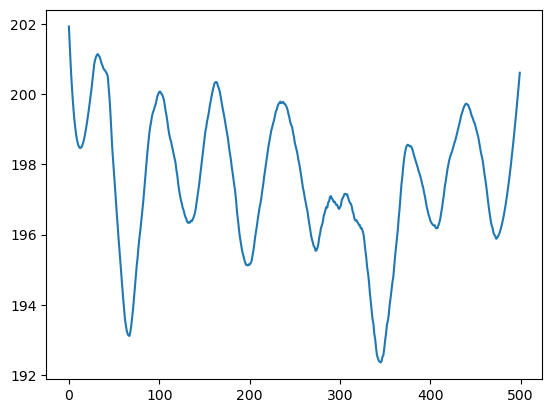

In [16]:
plt.plot(savgol_filter(nasal_resp, 51, 3))